# Comparing raw counts

Our expected raw counts for this comparison are drawn from the BRCA1 saturation genome editing (SGE) experiment by Findlay *et al.*. 

> Findlay, G.M., Daza, R.M., Martin, B. *et al.*   
> **Accurate classification of BRCA1 variants with saturation genome editing.**  
> *Nature 562, 217–222 (2018).*   
> [https://doi.org/10.1038/s41586-018-0461-z](https://doi.org/10.1038/s41586-018-0461-z)

For this example, 6 samples were quantified which correspond to Findlay's BRCA1 exon 2 (X2) experiment:

* plasmid
* negative control
* day 5 (2 replicates)
* day 11 (2 replicates)

Our observed raw counts for this comparison were generated using [QUANTS](https://github.com/cancerit/QUANTS) to determine the abundance of oligos designed with [VaLiAnT](https://github.com/cancerit/VaLiAnT) (based on saturation mutagenesis of BRCA1 exon 2 including PAM protection edits from the Findlay *et al.* experiment).

***

## Loading R library dependencies

Before we start, we need to load R library dependencies. These are only required for this example, they are not a dependency of QUANTS.

In [1]:
library(tidyverse)
library(scales)
library(hrbrthemes)
library(RColorBrewer)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow



***

## Expected counts

Expected raw counts from Findlay *et al.* were merged with their corresponding VaLiAnT oligos and annotations in [prepare_quants_inputs.ipynb](prepare_quants_inputs.ipynb) and written to [combined_findlay_valiant_annotations_and_counts.tsv](combined_findlay_valiant_annotations_and_counts.tsv).

In [2]:
# Read in expected counts and oligo annotations
expected_counts <- read.delim('combined_findlay_valiant_annotations_and_counts.tsv', 
                              header = T, sep = "\t", check.names = F)

# Gather expected counts and rename count columns to match sample names
expected_counts_narrow <- expected_counts %>%
    select(oligo_name, 
           'X2_lib' = 'library', 'X2_neg' = 'negative',
           'X2rL41_pre' = 'd5.r1', 'X2rL42_pre' = 'd5.r2',
           'X2rL41_post' = 'd11.r1', 'X2rL42_post' = 'd11.r2') %>%
    gather(sample, expected_counts, -oligo_name)

# Show data frame
head(expected_counts_narrow)

,oligo_name,sample,expected_counts
,<chr>,<chr>,<int>
1,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>G_snv_rc,X2_lib,828
2,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>C_snv_rc,X2_lib,1229
3,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>A_snv_rc,X2_lib,867
4,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>T_snv_rc,X2_lib,681
5,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>G_snv_rc,X2_lib,797
6,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>C_snv_rc,X2_lib,878


***

## Observed counts

Observed counts come from the QUANTS pipeline output files `example_output/results/pycroquet/<sample_name>_merged.query_to_library_counts.tsv.gz` which will need to be collated into a single data frame.

In [3]:
# Get matching file paths
pyc_results_files <- list.files(path = "example_output/results/pycroquet/", 
                                   pattern = "*_merged.query_to_library_counts.tsv.gz", 
                                   full.names = T, recursive = T)

# Loop over files and create a data frame
observed_counts <- data.frame()
for (i in pyc_results_files) {
    # Get sample name
    sample_name <- str_replace(basename(i), '_merged.query_to_library_counts.tsv.gz', '')
    # Read in count file setting column headers to allow merging of datasets
    tmp <- read.delim(i, header = T, sep = "\t", skip = 2, col.names = c('oligo_name', 'sgrna_ids', 'sgrna_seqs', 'gene_pair_id', 'observed_counts'))
    # Remove unwanted columns and set sample name
    tmp <- tmp %>%
        select(oligo_name, observed_counts) %>%
        mutate('sample' = sample_name, .after = 'oligo_name') 
    # Add to combined observed count data frame
    if (nrow(observed_counts) == 0) {
        observed_counts <- tmp
    } else {
        observed_counts <- rbind(observed_counts, tmp)
    }
}

# Show data frame
head(observed_counts)

,oligo_name,sample,observed_counts
,<chr>,<chr>,<int>
1,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>G_snv_rc,X2_lib,826
2,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>C_snv_rc,X2_lib,1227
3,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>A_snv_rc,X2_lib,865
4,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>T_snv_rc,X2_lib,679
5,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>G_snv_rc,X2_lib,795
6,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>C_snv_rc,X2_lib,876


***

## Combine observed and expected raw counts

Because we've renamed the columns in our expected and observed datasets, a simple join is required to combine the two datasets into a single data frame for comparison.

In [4]:
# Combine expected and observed raw counts
combined_counts <- expected_counts_narrow %>%
    left_join(observed_counts, by = c('oligo_name', 'sample'))

# Rename samples
combined_counts <- combined_counts %>%
 mutate(sample_label = as.list(case_when(
  sample == 'X2_lib' ~ expression(paste(bolditalic("BRCA1"), bold("exon2 library"))),
  sample == 'X2_neg' ~ expression(paste(bolditalic("BRCA1"), bold("exon2 negative control"))),
  sample == 'X2rL41_pre' ~ expression(paste(bolditalic("BRCA1"), bold("exon2 D5 Rep1"))),
  sample == 'X2rL41_post' ~ expression(paste(bolditalic("BRCA1"), bold("exon2 D11 Rep1"))),
  sample == 'X2rL42_pre' ~ expression(paste(bolditalic("BRCA1"), bold("exon2 D5 Rep2"))),
  sample == 'X2rL42_post' ~ expression(paste(bolditalic("BRCA1"), bold("exon2 D11 Rep2"))))))

# Show data frame
head(combined_counts)

,oligo_name,sample,expected_counts,observed_counts,sample_label
,<chr>,<chr>,<int>,<int>,<list>
1,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>G_snv_rc,X2_lib,828,826,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))"
2,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>C_snv_rc,X2_lib,1229,1227,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))"
3,ENST00000357654.9.ENSG00000012048.23_chr17:43124096_T>A_snv_rc,X2_lib,867,865,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))"
4,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>T_snv_rc,X2_lib,681,679,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))"
5,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>G_snv_rc,X2_lib,797,795,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))"
6,ENST00000357654.9.ENSG00000012048.23_chr17:43124095_A>C_snv_rc,X2_lib,878,876,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))"


### Plotting expected vs observed raw counts

We split the plots into library and screened samples due to the difference in the count ranges.

In [5]:
# Set a static sample palette by sample
palette <- brewer.pal(6,"Set1")
names(palette) = unique(combined_counts$sample)

First, we plot each sample individually. X2_neg was excluded due to high proportion of very low counts.

In [6]:
# Create list for plots
sample_count_plot_list <- list()

# Loop over sample names
for (sn in unique(combined_counts$sample)) {
 if (sn == "X2_neg") { next } # Skip X2_neg
    # Get sample label
    sl <- combined_counts %>% filter(sample == sn) %>% pull(sample_label) %>% unique()

    # Build the library counts plot
    sample_count_plot_list[[sn]] <- 
      ggplot(combined_counts %>% filter(sample == sn), 
           aes(x=expected_counts, y = observed_counts, label = oligo_name, fill = sample, color = sample)) +
      geom_point(size = 5, shape = 21, show.legend = FALSE, alpha = .4, color = 'black') +
      geom_abline(intercept = 0, slope = 1, alpha = 0.7, linetype = 'dashed') +
      scale_fill_manual(values = palette) +
      theme_ipsum(base_size = 30, axis_title_size = 30) +
      theme(panel.border = element_rect(color = 'black', fill = NA)) +
      theme(plot.title = element_text(size = 30)) +
      labs(title = as.expression(sl))
    
    # Set axis limits
    if (sn == "X2_lib") {
        sample_count_plot_list[[sn]] <- sample_count_plot_list[[sn]] +  
            scale_x_continuous(breaks = pretty_breaks(5), limits = c(0, 2000), name = 'expected counts') +
            scale_y_continuous(breaks = pretty_breaks(5), limits = c(0, 2000), name = 'observed counts')
    } else {
        sample_count_plot_list[[sn]] <- sample_count_plot_list[[sn]] +  
            scale_x_continuous(breaks = pretty_breaks(5), limits = c(0, 12000), name = 'expected counts') +
            scale_y_continuous(breaks = pretty_breaks(5), limits = c(0, 12000), name = 'observed counts') +
            theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1)) +
            theme(axis.title.x = element_text(margin = margin(t = 30, r = 0, b = 0, l = 0)))
    }
    
    # Save the individual sample counts plot
    ggsave(filename = file.path('plots', paste0(sn, '_expected_vs_observed.png')), 
           plot = sample_count_plot_list[[sn]], 
           device = 'png', width = 10, height = 10, dpi = 300)
}

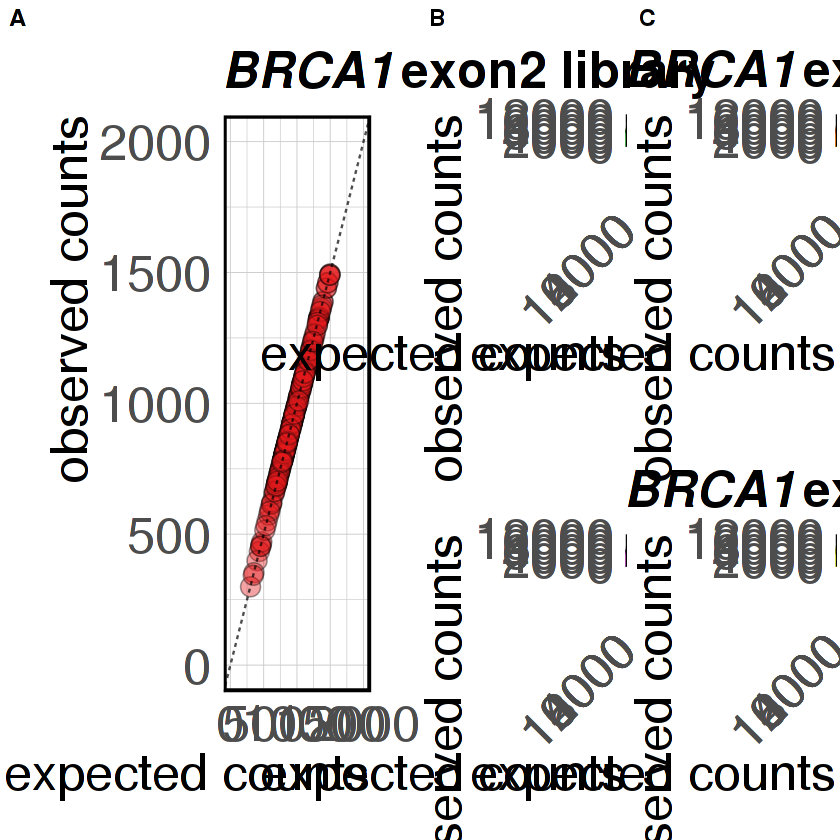

In [10]:
# Generate combined plot
# Rerun cell if you see errors
combined_sample_count_plot <- 
    ggarrange(sample_count_plot_list[['X2_lib']],                                                 
              ggarrange(sample_count_plot_list[['X2rL41_pre']], sample_count_plot_list[['X2rL41_post']], 
                        sample_count_plot_list[['X2rL42_pre']], sample_count_plot_list[['X2rL42_post']], 
                        ncol = 2, nrow = 2, labels = c("B", "C")), 
              ncol = 2, labels = "A") 

# Save the combined sample counts plots
    ggsave(filename = file.path('plots', 'combined_expected_vs_observed.png'), 
           plot = combined_sample_count_plot, 
           device = 'png', width = 32, height = 16, dpi = 300)

# Show plot
combined_sample_count_plot

## Calculate correlation between expected and observed counts per sample

We determined the Spearman’s correlation coefficient to describe the relationship between the observed and expected counts.

In [8]:
# Calculate correlation between each observed dataset to the expected counts
per_sample_correlation <- combined_counts %>% 
  group_by(sample, sample_label) %>%
  summarise('correlation' = cor(expected_counts, observed_counts, method = 'spearman'), .groups = 'keep')

# Show preview
head(per_sample_correlation)

sample,sample_label,correlation
<chr>,<list>,<dbl>
X2_lib,"paste(bolditalic(""BRCA1""), bold(""exon2 library""))",0.9999214
X2_neg,"paste(bolditalic(""BRCA1""), bold(""exon2 negative control""))",0.8341261
X2rL41_post,"paste(bolditalic(""BRCA1""), bold(""exon2 D11 Rep1""))",0.9186473
X2rL41_pre,"paste(bolditalic(""BRCA1""), bold(""exon2 D5 Rep1""))",0.9086432
X2rL42_post,"paste(bolditalic(""BRCA1""), bold(""exon2 D11 Rep2""))",0.9537422
X2rL42_pre,"paste(bolditalic(""BRCA1""), bold(""exon2 D5 Rep2""))",0.9276965


We can then plot these correlation coefficients, all of which (excluding negative control) are above 0.9.

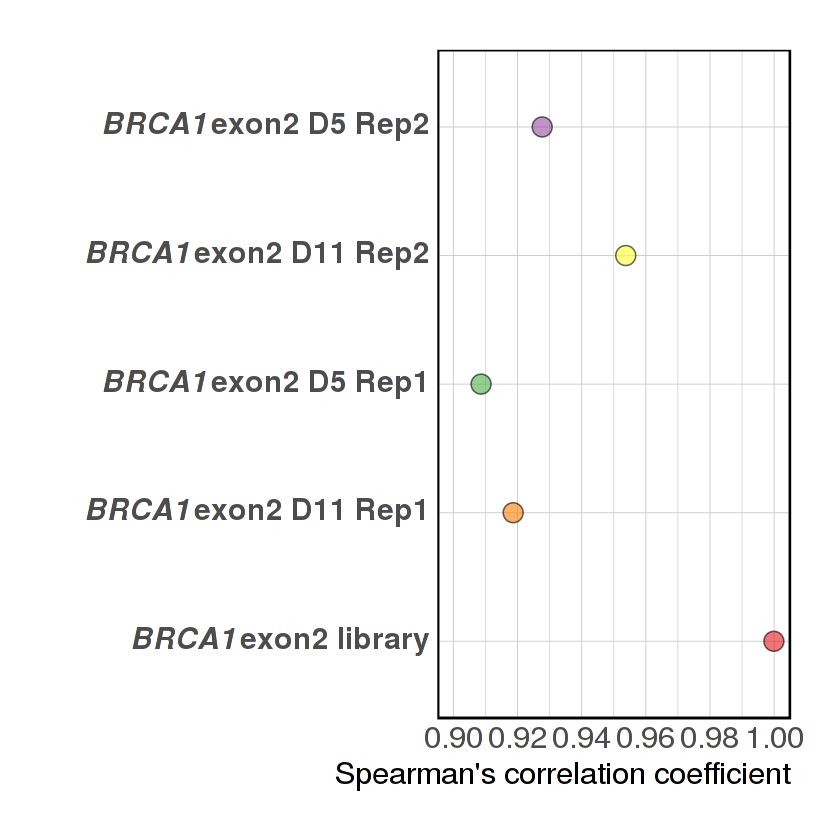

In [9]:
# Build the correlation plot
correlation_plot <- 
  ggplot(per_sample_correlation %>% filter(sample != 'X2_neg'), 
           aes(y = sample, x = correlation, fill = sample)) +
  geom_point(size = 5, shape = 21, show.legend = FALSE, alpha = .6, color = 'black') +
  scale_y_discrete(labels = per_sample_correlation %>% filter(sample != 'X2_neg') %>% pull(sample_label)) +
  scale_x_continuous(breaks = pretty_breaks(5), limits = c(0.9, 1)) +
  ylab('') +
  xlab("Spearman's correlation coefficient") +
  scale_fill_manual(values = palette) +
  theme_ipsum(base_size = 18, axis_title_size = 18) +
  theme(panel.border = element_rect(color = 'black', fill = NA))

# Save the correlation plot
ggsave(filename = 'plots/correlation_expected_vs_observed.png', 
       plot = correlation_plot, device = 'png', width = 12, height = 4, dpi = 300)

# Show the plot 
correlation_plot